In [1]:
import os
# Отключает все логи TensorFlow (0 - все, 1 - предупреждения, 2 - ошибки, 3 - критичные ошибки)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [172]:
from sklearn import datasets
import pandas as pd
import numpy as np
from typing import List, Union
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, IsolationForest
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
import time
from gower import gower_matrix
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from collections import Counter
from scipy.spatial.distance import pdist, squareform
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.svm import OneClassSVM
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import mutual_info_classif
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import torch
from torch.utils.data import Dataset, DataLoader
import time  
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from dotenv import load_dotenv
import neptune
import optuna
import time  
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, r2_score, mean_squared_error, make_scorer
import shap

# 1. Изучаем датасет. Удаляем или заполняем пропуски/NAN.

In [3]:
loan = pd.read_csv('content/loan_data.csv')

In [4]:
loan

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.0,male,Associate,47971.0,6,RENT,15000.0,MEDICAL,15.66,0.31,3.0,645,No,1
44996,37.0,female,Associate,65800.0,17,RENT,9000.0,HOMEIMPROVEMENT,14.07,0.14,11.0,621,No,1
44997,33.0,male,Associate,56942.0,7,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,10.0,668,No,1
44998,29.0,male,Bachelor,33164.0,4,RENT,12000.0,EDUCATION,13.23,0.36,6.0,604,No,1


In [5]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

### Нулевых/NAN данных нет. 

In [6]:
# Кодируем категориальные переменные (Label Encoding)
df_encoded = loan.copy()
label_encoders = {}

categorical_columns = df_encoded.select_dtypes(include=['object']).columns
for col in categorical_columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le


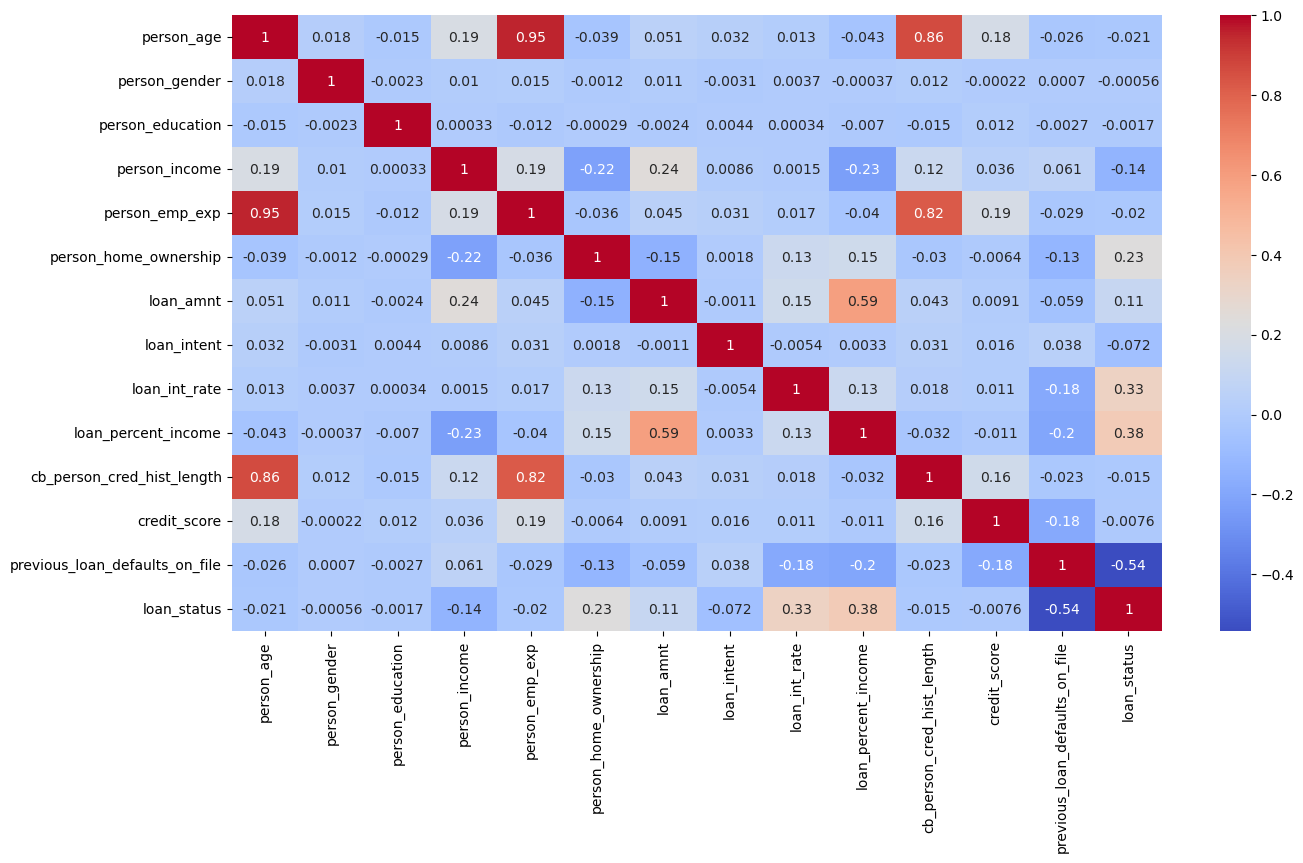

In [7]:
plt.figure(figsize=(15, 8))
sns.heatmap(df_encoded.corr(), annot=True, cmap="coolwarm")
plt.show()

### Т.к это классификация то коррелационные данные не сосбо показательны и лучше импользовать MI

### 3. Выделяем матрицу признаков и целевую переменную

In [8]:
# Убираем целевую переменную 
X = df_encoded.drop(columns=['loan_status'])
y = df_encoded.loan_status

## 4. Проверяем MI

In [9]:
mi_scores = mutual_info_classif(X, y)

# Оформляем результат в DataFrame
mi_scores = pd.Series(mi_scores, index=df_encoded.drop(columns=['loan_status']).columns)
mi_scores = mi_scores.sort_values(ascending=False)

# Выводим топ-10 признаков
print(mi_scores)

previous_loan_defaults_on_file    0.199852
person_income                     0.091693
loan_percent_income               0.084047
loan_int_rate                     0.070773
person_home_ownership             0.039184
loan_amnt                         0.017010
loan_intent                       0.008038
person_emp_exp                    0.003556
person_gender                     0.003010
person_age                        0.002317
person_education                  0.001591
cb_person_cred_hist_length        0.000000
credit_score                      0.000000
dtype: float64


### Мы получили что признаки credit_score, person_emp_exp, person_age, person_education - почти не будут иметь влияние на модель и их можно удалить

In [10]:
X

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file
0,22.0,0,4,71948.0,0,3,35000.0,4,16.02,0.49,3.0,561,0
1,21.0,0,3,12282.0,0,2,1000.0,1,11.14,0.08,2.0,504,1
2,25.0,0,3,12438.0,3,0,5500.0,3,12.87,0.44,3.0,635,0
3,23.0,0,1,79753.0,0,3,35000.0,3,15.23,0.44,2.0,675,0
4,24.0,1,4,66135.0,1,3,35000.0,3,14.27,0.53,4.0,586,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.0,1,0,47971.0,6,3,15000.0,3,15.66,0.31,3.0,645,0
44996,37.0,0,0,65800.0,17,3,9000.0,2,14.07,0.14,11.0,621,0
44997,33.0,1,0,56942.0,7,3,2771.0,0,10.02,0.05,10.0,668,0
44998,29.0,1,1,33164.0,4,3,12000.0,1,13.23,0.36,6.0,604,0


In [11]:
X = df_encoded.drop(columns=['loan_status', 'credit_score', 'person_emp_exp', 'person_age', 'person_education'])

In [12]:
X

,person_gender,person_income,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,previous_loan_defaults_on_file
0,0,71948.0,3,35000.0,4,16.02,0.49,3.0,0
1,0,12282.0,2,1000.0,1,11.14,0.08,2.0,1
2,0,12438.0,0,5500.0,3,12.87,0.44,3.0,0
3,0,79753.0,3,35000.0,3,15.23,0.44,2.0,0
4,1,66135.0,3,35000.0,3,14.27,0.53,4.0,0
...,...,...,...,...,...,...,...,...,...
44995,1,47971.0,3,15000.0,3,15.66,0.31,3.0,0
44996,0,65800.0,3,9000.0,2,14.07,0.14,11.0,0
44997,1,56942.0,3,2771.0,0,10.02,0.05,10.0,0
44998,1,33164.0,3,12000.0,1,13.23,0.36,6.0,0


## 5. Проверяем мультиколлинеарность через VIF.

In [13]:
# Рассчитаем VIF (коэффициент инфляции дисперсии)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns 
vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

# Выводим признаки с VIF > 10
vif_data[vif_data["VIF"] > 10]

,Feature,VIF


### Вывод: Мультиколлинеарных данных нет.

## 6. Аномалии:

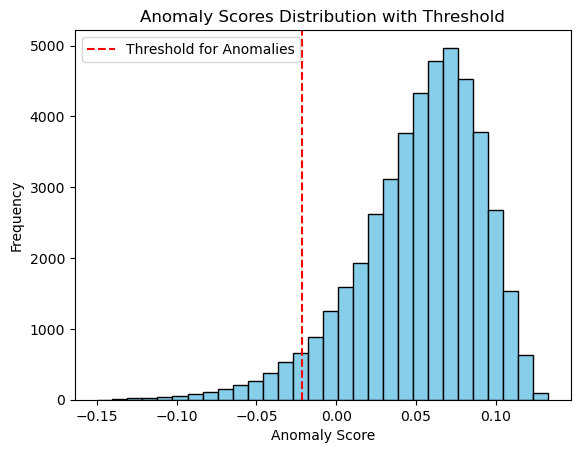

Аномалии (с динамическим порогом):
[0 1 1 ... 1 1 1]


In [14]:
# Инициализация модели Isolation Forest
iso_forest = IsolationForest(contamination=0.1)

# Обучение модели и предсказание меток (1 - нормальная точка, -1 - аномальная)
y_pred_iso = iso_forest.fit_predict(X)

# Получение аномальных баллов (чем ниже значение, тем более аномально)
anomaly_scores = iso_forest.decision_function(X)

# Визуализация гистограммы аномальных баллов
plt.hist(anomaly_scores, bins=30, color='skyblue', edgecolor='black')
plt.axvline(x=np.percentile(anomaly_scores, 5), color='red', linestyle='--', label='Threshold for Anomalies')
plt.title("Anomaly Scores Distribution with Threshold")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Динамическое определение порога для аномалий на основе 5% наименьших значений
threshold = np.percentile(anomaly_scores, 5)  # Для выделения 5% самых аномальных точек

# Классификация на основе динамического порога
y_pred_custom = (anomaly_scores > threshold).astype(int)  # 1 - нормальные, 0 - аномальные

# Проверка результатов классификации
print("Аномалии (с динамическим порогом):")
print(y_pred_custom)

In [15]:
# Отберем нормальные индексы чтобы удалить аномалии из датасета
normal_indices = np.where(y_pred_custom == 1)[0]

# Создание нового датасета без аномалий (отбор только нормальных точек)
X_without_anomalies = X.iloc[normal_indices]  # Используем iloc для правильного индексирования строк
y_without_anomalies = y.iloc[normal_indices]  # Если y - это DataFrame или Series

# Проверка размера нового датасета
print("Размер исходного датасета:", X.shape)
print("Размер датасета без аномалий:", X_without_anomalies.shape)

Размер исходного датасета: (45000, 9)
Размер датасета без аномалий: (42750, 9)


## 7.  Нормализация

In [16]:
scaler = StandardScaler()
X_scaler = scaler.fit_transform(X_without_anomalies)
df_x_scaler = pd.DataFrame(X_scaler, columns=X_without_anomalies.columns) 

## 8. Понижение размерности. Т.к это классификация будем пробовать через PCA/LDA

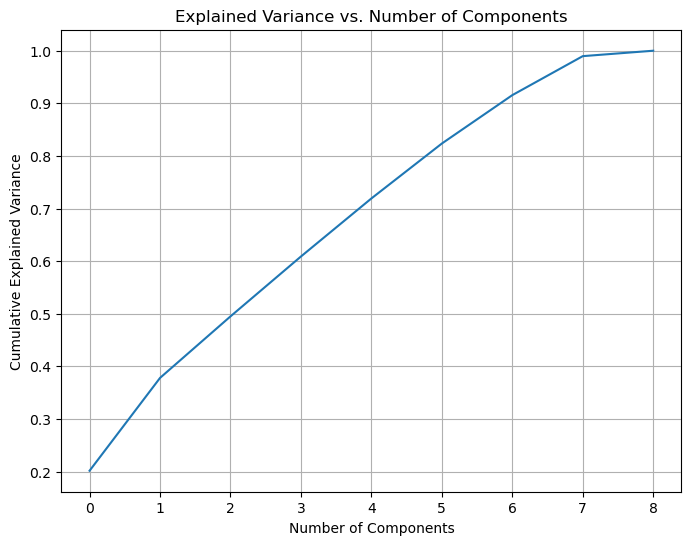

In [17]:
pca = PCA().fit(X_scaler)

# Визуализация
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

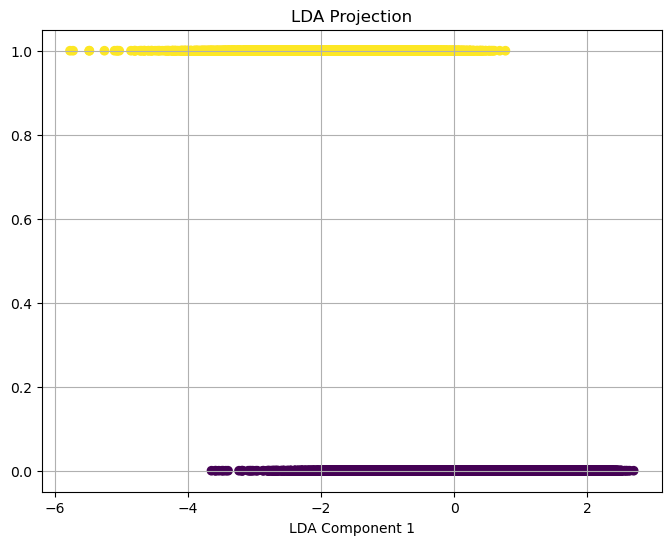

In [18]:
lda = LinearDiscriminantAnalysis(n_components=1)  # Параметр n_components = 1, так как классов 2
X_lda = lda.fit_transform(X_scaler, y_without_anomalies)

# Визуализация результатов LDA
plt.figure(figsize=(8,6))
plt.scatter(X_lda[:, 0], y_without_anomalies, c=y_without_anomalies, cmap='viridis')
plt.xlabel('LDA Component 1')
plt.title('LDA Projection')
plt.grid(True)
plt.show()

### Вывод: исходя из полученных данных понижение размерности не целесообразно. Будем использотьва в дальнейшем почищенный датасет.

## 9. Моделирование.

In [19]:
# Разбиваем данные: 80% в train, 20% в test
X_train, X_test, y_train, y_test = train_test_split(X_scaler, y_without_anomalies, test_size=0.2, random_state=42, stratify=y_without_anomalies)

In [20]:
# Дополнительно Разбиваем данные: 80% в train, 20% в test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [21]:
# Конвертируем данные в тензоры
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)  # Для бинарной классификации

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)

# Проверка размерностей
print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"y_train_tensor shape: {y_train_tensor.shape}")
print(f"X_test_tensor shape: {X_test_tensor.shape}")
print(f"y_test_tensor shape: {y_test_tensor.shape}")
print(f"X_val_tensor shape: {X_val_tensor.shape}")
print(f"y_val_tensor shape: {y_val_tensor.shape}")

X_train_tensor shape: torch.Size([27360, 9])
y_train_tensor shape: torch.Size([27360, 1])
X_test_tensor shape: torch.Size([8550, 9])
y_test_tensor shape: torch.Size([8550, 1])
X_val_tensor shape: torch.Size([6840, 9])
y_val_tensor shape: torch.Size([6840, 1])


In [22]:
load_dotenv()

True

In [23]:
run = neptune.init_run(
        project=os.getenv("NEPTUNE_PROJECT"), 
        api_token=os.getenv("NEPTUNE_API_TOKEN"),
        capture_stdout=True,
        capture_stderr=True,
        capture_traceback=True,
        capture_hardware_metrics=True
    ) 

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/saatarko/financescoring/e/FIN-37


In [24]:
class LoanDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = X
        self.y = y  

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            # Возвращаем как тензоры
            return self.X[idx].float(), self.y[idx].float()
        return self.X[idx].float()

# Создаём датасеты
train_dataset = LoanDataset(X_train_tensor, y_train_tensor)
val_dataset = LoanDataset(X_val_tensor, y_val_tensor)  
test_dataset = LoanDataset(X_test_tensor, y_test_tensor)

### Построим модель на pytorch

In [108]:
# === 1. Устанавливаем лучшие параметры ===
best_config = {
    "learning_rate": 0.001,
    "batch_size": 64,
    "dropout": 0.1,  
    "activation": "relu", 
    "optimizer": "Adam",
    "layers": 128
}

# === 2. Определяем устройство ===
device = "cuda" if torch.cuda.is_available() else "cpu"

# === 3. Подготовка данных ===
train_loader_final = DataLoader(train_dataset, batch_size=best_config["batch_size"], shuffle=True)
test_loader_final = DataLoader(test_dataset, batch_size=best_config["batch_size"], shuffle=False)

# === 4. Обновленная модель ===
class SimpleNN(nn.Module):
    def __init__(self, dropout, activation, input_dim):
        super(SimpleNN, self).__init__()

        # Выбор функции активации на основе параметра
        if activation == "relu":
            self.activation1 = nn.ReLU()
            self.activation2 = nn.ReLU()
        elif activation == "tanh":
            self.activation1 = nn.Tanh()
            self.activation2 = nn.Tanh()
        else:
            raise ValueError("Unsupported activation function")

        self.layer1 = nn.Linear(input_dim, 64)
        self.dropout1 = nn.Dropout(dropout)

        self.layer2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(dropout)

        self.output = nn.Linear(32, 1)  # Выходной слой без сигмоиды

    def forward(self, x):
        x = self.activation1(self.layer1(x))
        x = self.dropout1(x)
        x = self.activation2(self.layer2(x))
        x = self.dropout2(x)
        x = self.output(x)  # Линейный выход без сигмоиды
        return torch.sigmoid(x)  # Применяем сигмоиду
        
# Инициализируем модель
model_final = SimpleNN(
    dropout=best_config["dropout"],
    activation=best_config["activation"],
    input_dim=X_scaler.shape[1]
).to(device)

# === 5. Новый loss и оптимизатор ===
criterion = nn.BCEWithLogitsLoss()  # Мы применяем сигмоиду на выходе модели
optimizer = optim.Adam(model_final.parameters(), lr=best_config["learning_rate"])

# === 6. Обучение модели ===
epochs = 600
best_val_loss = float("inf")
patience = 30
epochs_no_improve = 0
best_model_wts = None
train_losses_final = []
val_losses_final = []

for epoch in range(epochs):
    model_final.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader_final:
        inputs, labels = inputs.to(device), labels.to(device).float()  # Метки float
        optimizer.zero_grad()
        outputs = model_final(inputs).view(-1, 1)  # Приводим к правильной форме
        loss = criterion(outputs, labels.view(-1, 1))  # Форматируем метки
        loss.backward()
        torch.nn.utils.clip_grad_value_(model_final.parameters(), clip_value=1.0)  # ограничение градиентов
        optimizer.step()
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader_final)
    train_losses_final.append(avg_train_loss)

    # === 8. Валидация ===
    model_final.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in test_loader_final:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model_final(inputs).view(-1, 1)
            loss = criterion(outputs, labels.view(-1, 1))
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(test_loader_final)
    val_losses_final.append(avg_val_loss)

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.6f}, Val Loss={avg_val_loss:.6f}")

    # Ранняя остановка
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_wts = model_final.state_dict()
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print(f"⏹️ Early stopping at epoch {epoch+1}")
        break

# === 10. Загружаем лучшие веса модели ===
if best_model_wts is not None:
    model_final.load_state_dict(best_model_wts)
    print("✅ Загружены лучшие веса модели.")

# === 11. Сохраняем обученную модель ===
model_path = "final_model.pth"
torch.save(model_final.state_dict(), model_path)
print(f"📁 Модель сохранена в '{model_path}'")

Epoch 1: Train Loss=0.691711, Val Loss=0.661776
Epoch 2: Train Loss=0.661104, Val Loss=0.659279
Epoch 3: Train Loss=0.658628, Val Loss=0.656931
Epoch 4: Train Loss=0.657220, Val Loss=0.655839
Epoch 5: Train Loss=0.656155, Val Loss=0.655259
Epoch 6: Train Loss=0.655592, Val Loss=0.655142
Epoch 7: Train Loss=0.655162, Val Loss=0.654000
Epoch 8: Train Loss=0.654473, Val Loss=0.653602
Epoch 9: Train Loss=0.653746, Val Loss=0.653492
Epoch 10: Train Loss=0.654302, Val Loss=0.653408
Epoch 11: Train Loss=0.653661, Val Loss=0.652841
Epoch 12: Train Loss=0.653229, Val Loss=0.652899
Epoch 13: Train Loss=0.653280, Val Loss=0.653020
Epoch 14: Train Loss=0.653440, Val Loss=0.652496
Epoch 15: Train Loss=0.653013, Val Loss=0.652835
Epoch 16: Train Loss=0.652564, Val Loss=0.652412
Epoch 17: Train Loss=0.652310, Val Loss=0.652336
Epoch 18: Train Loss=0.652667, Val Loss=0.652251
Epoch 19: Train Loss=0.652074, Val Loss=0.652289
Epoch 20: Train Loss=0.652185, Val Loss=0.652282
Epoch 21: Train Loss=0.651625

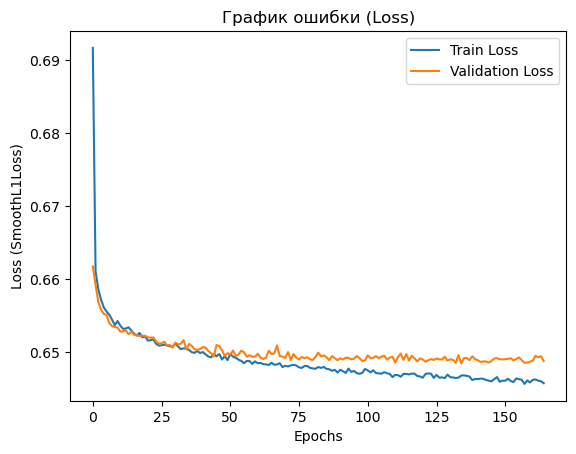

In [109]:
# График ошибки
plt.plot(train_losses_final, label='Train Loss')
plt.plot(val_losses_final, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (SmoothL1Loss)')
plt.legend()
plt.title('График ошибки (Loss)')
plt.show()

Test Loss: 1.769865
Accuracy: 0.909123
Precision: 0.897341
Recall: 0.655693
F1-score: 0.757717
ROC-AUC: 0.957743


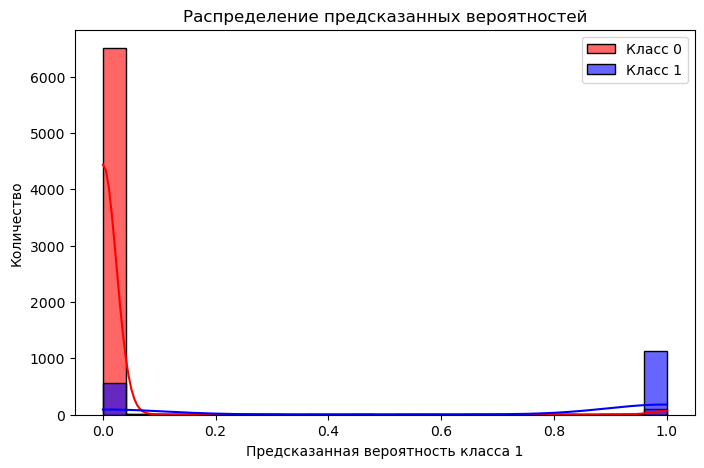

In [110]:
# Переводим модель в режим оценки
model_final.eval()

# Переменные для хранения метрик
y_true = y_test_tensor.cpu().numpy().flatten()  # Преобразуем в numpy
y_pred_final = []

# Включаем отключение градиентов
with torch.no_grad():
    # Предсказания
    y_pred_tensor = model_final(X_test_tensor.to(device))  
    y_pred_tensor = y_pred_tensor.cpu().numpy().reshape(-1)  # Приводим к форме [N]

    # Применяем порог 0.5 для бинарной классификации
    y_pred_binary = (y_pred_tensor >= 0.5).astype(int)
    
    # Вычисляем тестовую потерю
    criterion = nn.BCELoss()  
    loss = criterion(torch.tensor(y_pred_tensor, dtype=torch.float32), y_test_tensor.cpu().squeeze())  
    test_loss = loss.item()

# Вычисляем метрики
accuracy = accuracy_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)
roc_auc = roc_auc_score(y_true, y_pred_tensor)  # Используем вероятности, а не бинарные предсказания

# Выводим результаты
print(f"Test Loss: {test_loss:.6f}")
print(f"Accuracy: {accuracy:.6f}")
print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1-score: {f1:.6f}")
print(f"ROC-AUC: {roc_auc:.6f}")

plt.figure(figsize=(8, 5))
sns.histplot(y_pred_tensor[y_true == 0], bins=25, color="red", label="Класс 0", kde=True, alpha=0.6)
sns.histplot(y_pred_tensor[y_true == 1], bins=25, color="blue", label="Класс 1", kde=True, alpha=0.6)

plt.xlabel("Предсказанная вероятность класса 1")
plt.ylabel("Количество")
plt.title("Распределение предсказанных вероятностей")
plt.legend()
plt.show()

<Figure size 600x500 with 0 Axes>

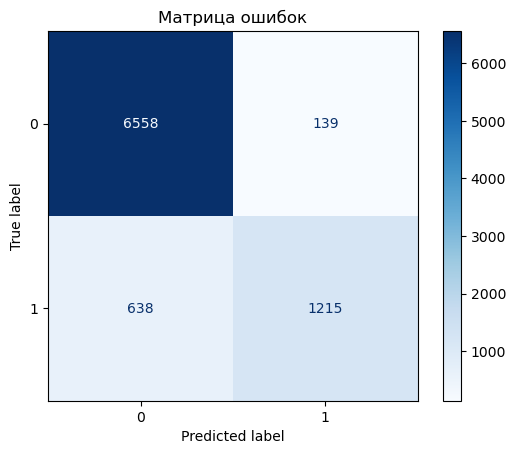

In [111]:
# Вычисляем матрицу ошибок
cm = confusion_matrix(y_true, y_pred_binary)  # Где y_true — фактические значения, y_pred_binary — предсказания (0 или 1)

# Отображаем матрицу
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")

plt.title("Матрица ошибок")
plt.show()


## 10. После обучения анализируем SHAP

ExactExplainer explainer: 8551it [02:29, 53.44it/s]                                                                                                                                                                                                                                                                 


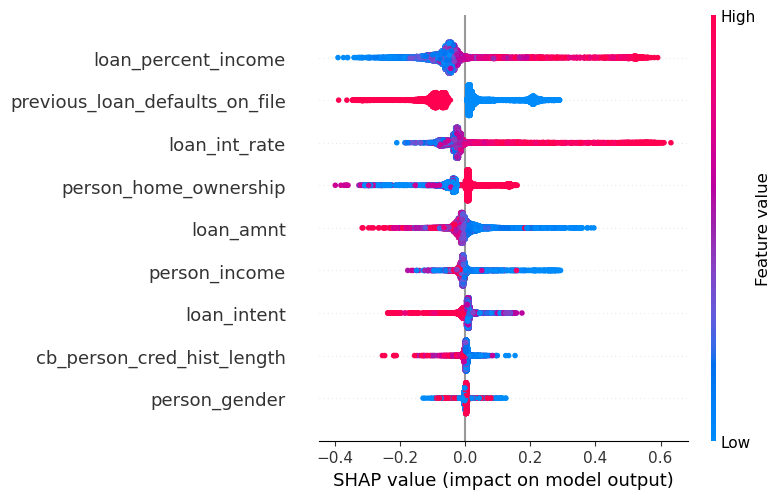

In [126]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Функция для выполнения предсказания через модель
def model_predict(x):
    # Убедитесь, что входные данные — это torch.Tensor
    x = torch.tensor(x, dtype=torch.float32)  # Если x это numpy.ndarray
    x = x.to(device)  # Переносим на тот же девайс, где модель
    model_final.eval()  # Убедитесь, что модель в режиме "оценки"
    with torch.no_grad():
        return model_final(x).cpu().numpy()  # Возвращаем на CPU и конвертируем в numpy

# Инициализируем SHAP объяснитель с кастомной функцией предсказания
my_explainer = shap.Explainer(model_predict, X_test)

# Получаем SHAP значения
shap_values = my_explainer(X_test)

# Строим график
shap.summary_plot(shap_values, X_test, feature_names=df_x_scaler.columns)

## Наиболее значимые признаки:
previous_loan_defaults_on_file_Yes – наличие дефолтов по предыдущим кредитам сильно влияет на прогноз.
loan_percent_income – процент кредита от дохода заемщика также критичен.
loan_int_rate – процентная ставка по кредиту.
loan_amnt – сумма кредита.

Интрепретация:
previous_loan_defaults_on_file_Yes: если человек имел дефолт, это значительно увеличивает вероятность негативного исхода (смещает SHAP-значения вправо).
credit_score: высокий кредитный рейтинг (красные точки) снижает риск (отрицательные SHAP-значения), а низкий (синие точки) – повышает.
loan_percent_income: высокий процент кредита от дохода увеличивает риск (большие положительные SHAP-значения).

Вывод:
Факторы, связанные с финансовой надежностью клиента (дефолты, кредитный рейтинг, процент от дохода), являются ключевыми в принятии решения моделью.
Модель делает выводы логично: большие кредиты с высокой ставкой и высокой нагрузкой на доход повышают риск невозврата.

## Датасет Paris Housing

## 1. Изучаем датасет. Удаляем или заполняем пропуски/NAN.

In [127]:
paris = pd.read_csv('content/ParisHousing.csv')

In [128]:
paris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   squareMeters       10000 non-null  int64  
 1   numberOfRooms      10000 non-null  int64  
 2   hasYard            10000 non-null  int64  
 3   hasPool            10000 non-null  int64  
 4   floors             10000 non-null  int64  
 5   cityCode           10000 non-null  int64  
 6   cityPartRange      10000 non-null  int64  
 7   numPrevOwners      10000 non-null  int64  
 8   made               10000 non-null  int64  
 9   isNewBuilt         10000 non-null  int64  
 10  hasStormProtector  10000 non-null  int64  
 11  basement           10000 non-null  int64  
 12  attic              10000 non-null  int64  
 13  garage             10000 non-null  int64  
 14  hasStorageRoom     10000 non-null  int64  
 15  hasGuestRoom       10000 non-null  int64  
 16  price              1000

## 2.Строим матрицу корреляции

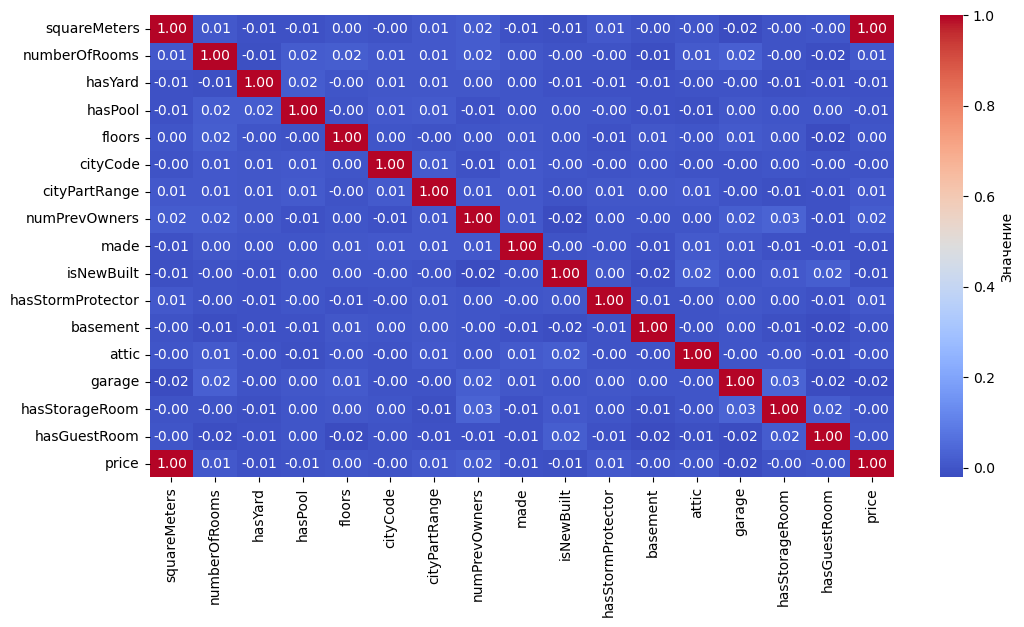

In [129]:
plt.figure(figsize=(12, 6)) 
sns.heatmap(paris.corr(), annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={'label': 'Значение'})
plt.show()

### Интересные данные: исключительно низкая корреляция всех параметров кроме метража. Попробую потестировать дополнительно например MI

## 3.Выделяем матрицу признаков и целевую переменную

In [134]:
# Убираем целевую переменную 
X_paris = paris.drop(columns=['price'])
y_paris = paris['price']

## 4. Проверяем MI

In [135]:
mi_scores_paris = mutual_info_regression(X_paris, y_paris)

# Оформляем результат в DataFrame
mi_scores = pd.Series(mi_scores_paris, index=X_paris.columns)
mi_scores = mi_scores.sort_values(ascending=False)

# Выводим топ-10 признаков
print(mi_scores.head(10))

squareMeters     6.566407
cityCode         0.026302
numPrevOwners    0.012794
cityPartRange    0.011770
hasYard          0.007757
numberOfRooms    0.007486
floors           0.006031
attic            0.005404
isNewBuilt       0.004287
hasGuestRoom     0.002099
dtype: float64


### Попробуем удалить hasGuestRoom

In [136]:
X_paris = paris.drop(columns=['price','hasGuestRoom'])

## 5. Проверяем мультиколлинеарность через VIF.

In [137]:
# Рассчитаем VIF (коэффициент инфляции дисперсии)
vif_data = pd.DataFrame()
vif_data["Feature"] = X_paris.columns 
vif_data["VIF"] = [variance_inflation_factor(X_paris, i) for i in range(X_paris.shape[1])]

# Выводим признаки с VIF > 10
vif_data[vif_data["VIF"] > 10]

,Feature,VIF
8,made,35.080547


### Удаялем made т.к VIF >10

In [138]:
X_paris = paris.drop(columns=['price','hasGuestRoom','made'])

## 6. Аномалии

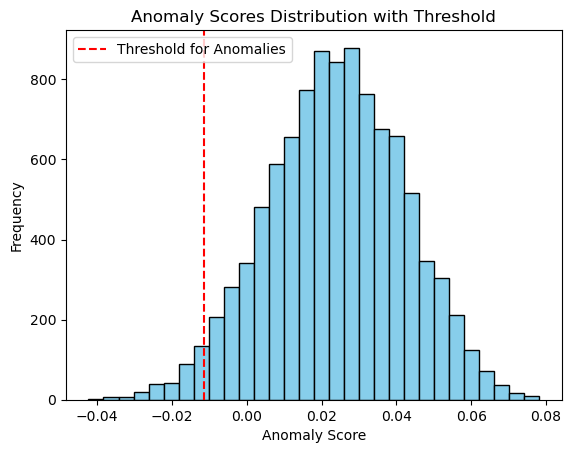

Аномалии (с динамическим порогом):
[1 1 1 ... 1 1 1]


In [150]:
# Инициализация модели Isolation Forest
iso_forest_paris = IsolationForest(contamination=0.1)

# Обучение модели и предсказание меток (1 - нормальная точка, -1 - аномальная)
y_pred_iso_paris = iso_forest_paris.fit_predict(X_paris)

# Получение аномальных баллов (чем ниже значение, тем более аномально)
anomaly_scores_paris = iso_forest_paris.decision_function(X_paris)

# Визуализация гистограммы аномальных баллов
plt.hist(anomaly_scores_paris, bins=30, color='skyblue', edgecolor='black')
plt.axvline(x=np.percentile(anomaly_scores_paris, 3), color='red', linestyle='--', label='Threshold for Anomalies')
plt.title("Anomaly Scores Distribution with Threshold")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Динамическое определение порога для аномалий на основе 3% наименьших значений
threshold_paris = np.percentile(anomaly_scores_paris, 3)  # Для выделения 3% самых аномальных точек

# Классификация на основе динамического порога
y_pred_custom_paris = (anomaly_scores_paris > threshold_paris).astype(int)  # 1 - нормальные, 0 - аномальные

# Проверка результатов классификации
print("Аномалии (с динамическим порогом):")
print(y_pred_custom_paris)

In [151]:
# Отберем нормальные индексы чтобы удалить аномалии из датасета
normal_indices_paris = np.where(y_pred_custom_paris == 1)[0]

# Создание нового датасета без аномалий (отбор только нормальных точек)
X_paris_without_anomalies = X_paris.iloc[normal_indices_paris]  
y_paris_without_anomalies = y_paris.iloc[normal_indices_paris]   

# Проверка размера нового датасета
print("Размер исходного датасета:", X_paris.shape)
print("Размер датасета без аномалий:", X_paris_without_anomalies.shape)

Размер исходного датасета: (10000, 14)
Размер датасета без аномалий: (9700, 14)


## 7. Нормализуем данные

In [ ]:
В нашем случае данные уже похожи на нормализованные

## 8. Понижение размерности PCA

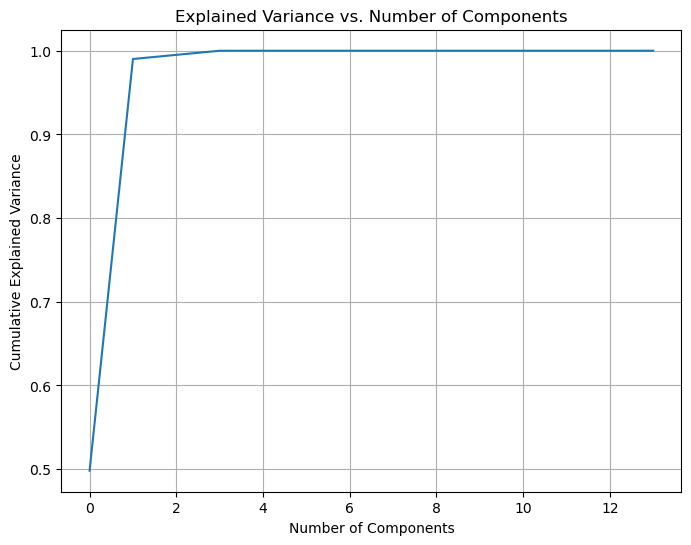

In [155]:
pca = PCA().fit(X_paris_without_anomalies)

# Визуализация
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

### Понижение размерности сомнительно- но можно разделить на 2 компонента

In [157]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_paris_without_anomalies)

df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])  

## 9. Моделирование

In [160]:
X_train_paris, X_test_paris, y_train_paris, y_test_paris = train_test_split(X_pca, y_paris_without_anomalies, test_size=0.2, random_state=42)

In [161]:
X_train_paris, X_val_paris, y_train_paris, y_val_paris = train_test_split(X_train_paris, y_train_paris, test_size=0.2, random_state=42)

In [164]:
# Конвертируем в тензоры
X_train_tensor_paris = torch.tensor(X_train_paris, dtype=torch.float32)
y_train_tensor_paris = torch.tensor(y_train_paris.values, dtype=torch.float32).unsqueeze(1)

X_test_tensor_paris = torch.tensor(X_test_paris, dtype=torch.float32)
y_test_tensor_paris = torch.tensor(y_test_paris.values, dtype=torch.float32).unsqueeze(1)

X_val_tensor_paris = torch.tensor(X_val_paris, dtype=torch.float32)
y_val_tensor_paris = torch.tensor(y_val_paris.values, dtype=torch.float32).unsqueeze(1)

In [165]:
class ParisDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = X
        self.y = y  

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            # Возвращаем как тензоры
            return self.X[idx].float(), self.y[idx].float()
        return self.X[idx].float()

# Создаём датасеты
train_dataset_paris = ParisDataset(X_train_tensor_paris, y_train_tensor_paris)
val_dataset_paris = ParisDataset(X_val_tensor_paris, y_val_tensor_paris)  
test_dataset_paris = ParisDataset(X_test_tensor_paris, y_test_tensor_paris)

In [175]:
# === 1. Устанавливаем лучшие параметры ===
best_config = {
    "learning_rate": 0.01,
    "batch_size": 32,
    "dropout": 0.10,  # округляем до 4 знаков
    "activation": "relu",
    "num_layers": 3,
    "optimizer": "Adam",
    "layers": 250
}

# === 2. Определяем устройство ===
device = "cuda" if torch.cuda.is_available() else "cpu"

# === 3. Подготовка данных ===
train_loader_paris = DataLoader(train_dataset_paris, batch_size=best_config["batch_size"], shuffle=True)
test_loader_paris = DataLoader(test_dataset_paris, batch_size=best_config["batch_size"], shuffle=False)

# === 4. Определяем модель ===
class SimpleNN(nn.Module):
    def __init__(self, hidden_size, dropout, activation, input_dim):
        super(SimpleNN, self).__init__()
        
        # Первый слой
        self.layer1 = nn.Linear(input_dim, hidden_size)
        self.activation1 = nn.ReLU() 
        self.dropout1 = nn.Dropout(dropout)

        # Второй слой
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.activation2 = nn.ReLU() 
        self.dropout2 = nn.Dropout(dropout)

        # Третий слой
        self.layer3 = nn.Linear(hidden_size, 1)  # Выходной слой (для регрессии)
    
    def forward(self, x):
        x = self.dropout1(self.activation1(self.layer1(x)))
        x = self.dropout2(self.activation2(self.layer2(x)))
        x = self.layer3(x)
        return x

# Инициализируем модель 
model_paris = SimpleNN(
    hidden_size=best_config["layers"],
    dropout=best_config["dropout"],
    activation=best_config["activation"],
    input_dim=X_pca.shape[1]  
).to(device)

# === 5. Определяем функцию потерь и оптимизатор ===
criterion = nn.SmoothL1Loss()  # Huber Loss
optimizer = optim.Adam(model_paris.parameters(), lr=best_config["learning_rate"])

# === 6. Создаём папку для логов TensorBoard ===
log_dir = f"tensorboard/{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)

# === 7. Обучение модели ===
epochs = 600
best_val_loss = float("inf")
patience = 30
epochs_no_improve = 0
best_model_wts = None
train_losses_paris = []
val_losses_paris = []

for epoch in range(epochs):
    model_paris.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader_paris:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_paris(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_value_(model_paris.parameters(), clip_value=1.0)  # ограничение градиентов
        optimizer.step()
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader_paris)
    train_losses_paris.append(avg_train_loss)  # Добавляем в список

    # === 8. Валидация ===
    model_paris.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in test_loader_paris:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_paris(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(test_loader_paris)

    val_losses_paris.append(avg_val_loss)  # Добавляем в список

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.6f}, Val Loss={avg_val_loss:.6f}")

    # === 9. Логируем данные в TensorBoard ===
    writer.add_scalar("Loss/Train", avg_train_loss, epoch)
    writer.add_scalar("Loss/Validation", avg_val_loss, epoch)

    # Логируем градиенты
    for name, param in model_paris.named_parameters():
        if param.grad is not None:
            writer.add_histogram(f"Gradients/{name}", param.grad, epoch)

    # Ранняя остановка
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_wts = model_paris.state_dict()  # Сохраняем лучшие веса
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print(f"⏹️ Early stopping at epoch {epoch+1}")
        break

# === 10. Загружаем лучшие веса модели ===
if best_model_wts is not None:
    model_paris.load_state_dict(best_model_wts)
    print("✅ Загружены лучшие веса модели.")

# === 11. Сохраняем обученную модель в папку с логами ===
model_path = os.path.join(log_dir, "paris_final_model.pth")
torch.save(model_paris.state_dict(), model_path)
print(f"📁 Модель сохранена в '{model_path}'")

# Закрываем TensorBoard writer
writer.close()

Epoch 1: Train Loss=1601226.488402, Val Loss=1357636.341189
Epoch 2: Train Loss=1351461.239691, Val Loss=1332609.360656
Epoch 3: Train Loss=1355587.638531, Val Loss=1331928.889344
Epoch 4: Train Loss=1361055.529961, Val Loss=1348208.840164
Epoch 5: Train Loss=1356771.370168, Val Loss=1372023.377049
Epoch 6: Train Loss=1394778.737113, Val Loss=1471697.618852
Epoch 7: Train Loss=1356020.366302, Val Loss=1344968.497951
Epoch 8: Train Loss=1365511.281894, Val Loss=1395813.739754
Epoch 9: Train Loss=1357037.164948, Val Loss=1334909.702869
Epoch 10: Train Loss=1369503.788982, Val Loss=1370488.108607
Epoch 11: Train Loss=1372658.604059, Val Loss=1365786.028689
Epoch 12: Train Loss=1361737.436211, Val Loss=1376343.151639
Epoch 13: Train Loss=1358866.971972, Val Loss=1333673.922131
Epoch 14: Train Loss=1360425.320554, Val Loss=1421161.510246
Epoch 15: Train Loss=1368741.539304, Val Loss=1341758.532787
Epoch 16: Train Loss=1363962.215851, Val Loss=1420505.144467
Epoch 17: Train Loss=1374705.3820

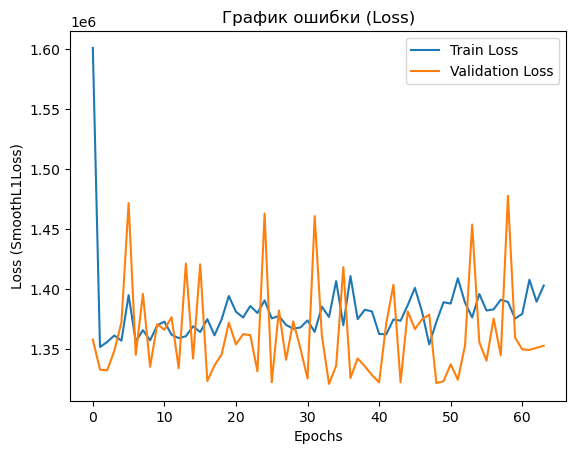

In [176]:
# График ошибки
plt.plot(train_losses_paris, label='Train Loss')
plt.plot(val_losses_paris, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (SmoothL1Loss)')
plt.legend()
plt.title('График ошибки (Loss)')
plt.show()

Test Loss: 2850181611520.000000
Mean Absolute Error (MAE): 1352812.711744
R²: 0.634388


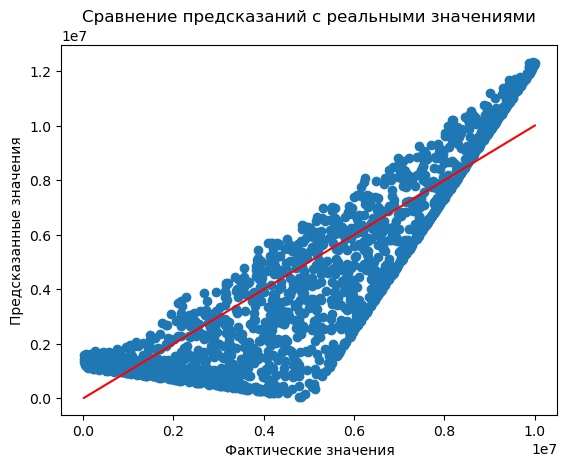

In [177]:
# Переводим модель в режим оценки
model_paris.eval()

# Переменная для хранения общей потери
test_loss = 0.0
n_samples = 0

# Переменные для расчетов MAE и R²
y_true_paris = torch.tensor(y_test_paris.values)  # Преобразуем pandas.Series в torch.Tensor
y_pred_paris = []

# Включаем отключение градиентов
with torch.no_grad():
    # Предсказания
    y_pred_tensor = model_paris(X_test_tensor_paris.to(device))  
    y_pred_tensor = y_pred_tensor.cpu().numpy()  # Переводим предсказания в numpy
    y_pred_paris = y_pred_tensor

    # Вычисляем тестовую потерю
    criterion = nn.MSELoss()  # Потери для регрессии
    loss = criterion(torch.tensor(y_pred_paris), y_test_tensor_paris)  # Включаем реальное y
    test_loss += loss.item() * y_test_tensor_paris.size(0)  # Умножаем на размер батча
    n_samples += y_test_tensor_paris.size(0)

    # Средняя потеря
    avg_test_loss = test_loss / n_samples

# Вычисляем MAE и R²
mae = mean_absolute_error(y_true_paris.numpy(), y_pred_paris)  # Конвертируем y_true в numpy
r2 = r2_score(y_true_paris.numpy(), y_pred_paris)

# Выводим среднюю потерю, MAE и R²
print(f"Test Loss: {avg_test_loss:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R²: {r2:.6f}")

# Строим график
plt.scatter(y_true_paris.numpy(), y_pred_paris)
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Сравнение предсказаний с реальными значениями')

# Линия идеального предсказания
plt.plot([min(y_true_paris.numpy()), max(y_true_paris.numpy())], [min(y_true_paris.numpy()), max(y_true_paris.numpy())], color='red') 

plt.show()


## Получилась очгеь плохая модель прпобуем пересчитать все для чистых данных без понижения размерности

## 10. Анализируем SHAP 

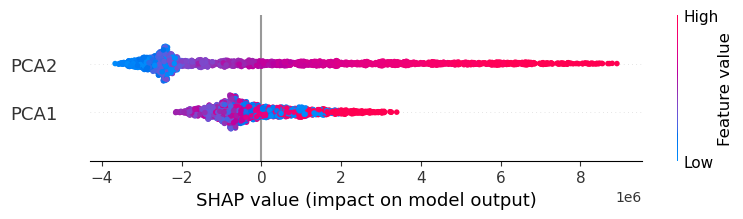

In [178]:
X_test_tensor_paris = torch.tensor(X_test_paris, dtype=torch.float32)

# Функция для выполнения предсказания через модель
def model_predict(x):
    # Убедитесь, что входные данные — это torch.Tensor
    x = torch.tensor(x, dtype=torch.float32)  # Если x это numpy.ndarray
    x = x.to(device)  # Переносим на тот же девайс, где модель
    model_paris.eval()  # Убедитесь, что модель в режиме "оценки"
    with torch.no_grad():
        return model_paris(x).cpu().numpy()  # Возвращаем на CPU и конвертируем в numpy

# Инициализируем SHAP объяснитель с кастомной функцией предсказания
my_explainer = shap.Explainer(model_predict, X_test_paris)

# Получаем SHAP значения
shap_values = my_explainer(X_test_paris)

# Строим график
shap.summary_plot(shap_values, X_test_paris, feature_names=df_pca.columns)

## 7. Нормализуем данные

### 9.1 Повторим моделирование без понижения размерности

In [193]:
X_train_paris2, X_test_paris2, y_train_paris2, y_test_paris2 = train_test_split(X_paris_without_anomalies, y_paris_without_anomalies, test_size=0.2, random_state=42)

In [194]:
X_train_paris2, X_val_paris2, y_train_paris2, y_val_paris2 = train_test_split(X_train_paris2, y_train_paris2, test_size=0.2, random_state=42)

In [221]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_paris2)
X_val_scaled = scaler.transform(X_val_paris2)
X_test_scaled = scaler.transform(X_test_paris2)
df_paris = pd.DataFrame(X_paris_without_anomalies, columns=X_paris_without_anomalies.columns)  

In [212]:
# Конвертация в тензоры
X_train_tensor_paris2 = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor_paris2 = torch.tensor(y_train_paris2.values, dtype=torch.float32).unsqueeze(1)

X_test_tensor_paris2 = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor_paris2 = torch.tensor(y_test_paris2.values, dtype=torch.float32).unsqueeze(1)

X_val_tensor_paris2 = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor_paris2 = torch.tensor(y_val_paris2.values, dtype=torch.float32).unsqueeze(1)

In [213]:
class ParisDataset2(Dataset):
    def __init__(self, X, y=None):
        self.X = X
        self.y = y  

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            # Возвращаем как тензоры
            return self.X[idx].float(), self.y[idx].float()
        return self.X[idx].float()

# Создаём датасеты
train_dataset_paris2 = ParisDataset2(X_train_tensor_paris2, y_train_tensor_paris2)
val_dataset_paris2 = ParisDataset2(X_val_tensor_paris2, y_val_tensor_paris2)  
test_dataset_paris2 = ParisDataset2(X_test_tensor_paris2, y_test_tensor_paris2)

In [215]:
# === 1. Устанавливаем лучшие параметры ===
best_config = {
    "learning_rate": 0.01,
    "batch_size": 32,
    "dropout": 0.10,  # округляем до 4 знаков
    "activation": "relu",
    "num_layers": 3,
    "optimizer": "Adam",
    "layers": 250
}

# === 2. Определяем устройство ===
device = "cuda" if torch.cuda.is_available() else "cpu"

# === 3. Подготовка данных ===
train_loader_paris2 = DataLoader(train_dataset_paris2, batch_size=best_config["batch_size"], shuffle=True)
test_loader_paris2 = DataLoader(test_dataset_paris2, batch_size=best_config["batch_size"], shuffle=False)

# === 4. Определяем модель ===
class SimpleNN(nn.Module):
    def __init__(self, hidden_size, dropout, activation, input_dim):
        super(SimpleNN, self).__init__()
        
        # Первый слой
        self.layer1 = nn.Linear(input_dim, hidden_size)
        self.activation1 = nn.ReLU() 
        self.dropout1 = nn.Dropout(dropout)

        # Второй слой
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.activation2 = nn.ReLU() 
        self.dropout2 = nn.Dropout(dropout)

        # Третий слой
        self.layer3 = nn.Linear(hidden_size, 1)  # Выходной слой (для регрессии)
    
    def forward(self, x):
        x = self.dropout1(self.activation1(self.layer1(x)))
        x = self.dropout2(self.activation2(self.layer2(x)))
        x = self.layer3(x)
        return x

# Инициализируем модель 
model_paris2 = SimpleNN(
    hidden_size=best_config["layers"],
    dropout=best_config["dropout"],
    activation=best_config["activation"],
    input_dim=X_paris.shape[1]  
).to(device)

# === 5. Определяем функцию потерь и оптимизатор ===
criterion = nn.SmoothL1Loss()  # Huber Loss
optimizer = optim.Adam(model_paris2.parameters(), lr=best_config["learning_rate"])

# === 6. Создаём папку для логов TensorBoard ===
log_dir = f"tensorboard/{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)

# === 7. Обучение модели ===
epochs = 600
best_val_loss = float("inf")
patience = 30
epochs_no_improve = 0
best_model_wts = None
train_losses_paris2 = []
val_losses_paris2 = []

for epoch in range(epochs):
    model_paris2.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader_paris2:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_paris2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_value_(model_paris2.parameters(), clip_value=1.0)  # ограничение градиентов
        optimizer.step()
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader_paris2)
    train_losses_paris2.append(avg_train_loss)  # Добавляем в список

    # === 8. Валидация ===
    model_paris2.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in test_loader_paris2:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_paris2(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(test_loader_paris2)

    val_losses_paris2.append(avg_val_loss)  # Добавляем в список

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.6f}, Val Loss={avg_val_loss:.6f}")

    # === 9. Логируем данные в TensorBoard ===
    writer.add_scalar("Loss/Train", avg_train_loss, epoch)
    writer.add_scalar("Loss/Validation", avg_val_loss, epoch)

    # Логируем градиенты
    for name, param in model_paris2.named_parameters():
        if param.grad is not None:
            writer.add_histogram(f"Gradients/{name}", param.grad, epoch)

    # Ранняя остановка
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_wts = model_paris2.state_dict()  # Сохраняем лучшие веса
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print(f"⏹️ Early stopping at epoch {epoch+1}")
        break

# === 10. Загружаем лучшие веса модели ===
if best_model_wts is not None:
    model_paris2.load_state_dict(best_model_wts)
    print("✅ Загружены лучшие веса модели.")

# === 11. Сохраняем обученную модель в папку с логами ===
model_path = os.path.join(log_dir, "paris_final_model.pth")
torch.save(model_paris2.state_dict(), model_path)
print(f"📁 Модель сохранена в '{model_path}'")

# Закрываем TensorBoard writer
writer.close()

Epoch 1: Train Loss=4845837.659794, Val Loss=4476475.684426
Epoch 2: Train Loss=3535450.822809, Val Loss=2181637.862705
Epoch 3: Train Loss=1055405.157619, Val Loss=348432.273566
Epoch 4: Train Loss=386918.495087, Val Loss=315595.542777
Epoch 5: Train Loss=363058.330783, Val Loss=288401.674436
Epoch 6: Train Loss=347916.255477, Val Loss=272248.893186
Epoch 7: Train Loss=331267.909472, Val Loss=255201.326076
Epoch 8: Train Loss=314347.269249, Val Loss=243494.309939
Epoch 9: Train Loss=299352.507329, Val Loss=225724.764857
Epoch 10: Train Loss=287976.698373, Val Loss=208099.117572
Epoch 11: Train Loss=271408.417928, Val Loss=189143.868852
Epoch 12: Train Loss=255418.523679, Val Loss=169518.323642
Epoch 13: Train Loss=242889.130718, Val Loss=146310.279329
Epoch 14: Train Loss=228830.702481, Val Loss=134479.330046
Epoch 15: Train Loss=215590.300338, Val Loss=121819.079278
Epoch 16: Train Loss=208102.181379, Val Loss=115827.466829
Epoch 17: Train Loss=197728.767155, Val Loss=89154.035092
Ep

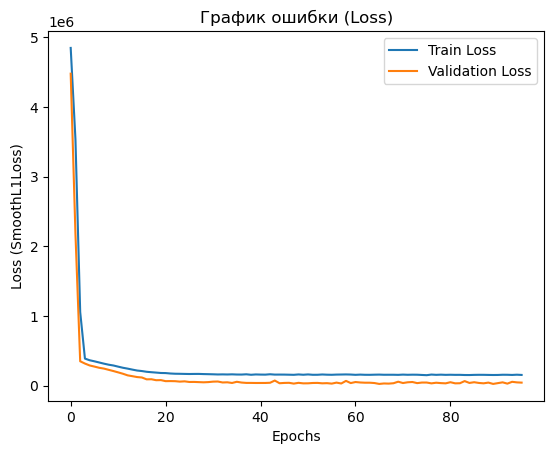

In [216]:
# График ошибки
plt.plot(train_losses_paris2, label='Train Loss')
plt.plot(val_losses_paris2, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (SmoothL1Loss)')
plt.legend()
plt.title('График ошибки (Loss)')
plt.show()

Test Loss: 2655193856.000000
Mean Absolute Error (MAE): 41993.479293
R²: 0.999659


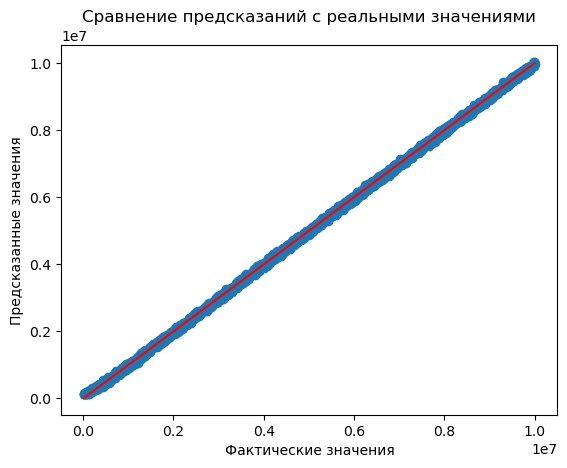

In [220]:
# Переводим модель в режим оценки
model_paris2.eval()

# Переменная для хранения общей потери
test_loss = 0.0
n_samples = 0

# Переменные для расчетов MAE и R²
y_true = torch.tensor(y_test_paris2.values)  # Преобразуем pandas.Series в torch.Tensor
y_pred_final = []

# Включаем отключение градиентов
with torch.no_grad():
    # Предсказания
    y_pred_tensor = model_paris2(X_test_tensor_paris2.to(device))  
    y_pred_tensor = y_pred_tensor.cpu().numpy()  # Переводим предсказания в numpy
    y_pred_final = y_pred_tensor

    # Вычисляем тестовую потерю
    criterion = nn.MSELoss()  # Потери для регрессии
    loss = criterion(torch.tensor(y_pred_final), y_test_tensor_paris2)  # Включаем реальное y
    test_loss += loss.item() * y_test_tensor_paris2.size(0)  # Умножаем на размер батча
    n_samples += y_test_tensor_paris2.size(0)

    # Средняя потеря
    avg_test_loss = test_loss / n_samples

# Вычисляем MAE и R²
mae = mean_absolute_error(y_true.numpy(), y_pred_final)  # Конвертируем y_true в numpy
r2 = r2_score(y_true.numpy(), y_pred_final)

# Выводим среднюю потерю, MAE и R²
print(f"Test Loss: {avg_test_loss:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R²: {r2:.6f}")

# Строим график
plt.scatter(y_true.numpy(), y_pred_final)
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Сравнение предсказаний с реальными значениями')

# Линия идеального предсказания
plt.plot([min(y_true.numpy()), max(y_true.numpy())], [min(y_true.numpy()), max(y_true.numpy())], color='red') 

plt.show()

# 10. Анализируем SHAP 

PermutationExplainer explainer: 1941it [00:40, 35.87it/s]                                                                                                                                                                                                                                                           


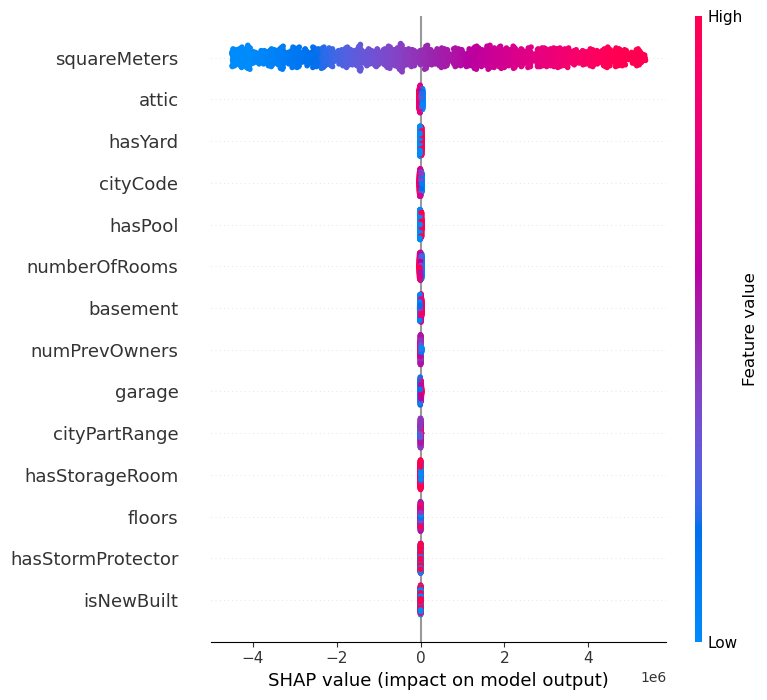

In [223]:
X_test_tensor_paris2 = torch.tensor(X_test_scaled, dtype=torch.float32)

# Функция для выполнения предсказания через модель
def model_predict(x):
    # Убедитесь, что входные данные — это torch.Tensor
    x = torch.tensor(x, dtype=torch.float32)  # Если x это numpy.ndarray
    x = x.to(device)  # Переносим на тот же девайс, где модель
    model_paris2.eval()  # Убедитесь, что модель в режиме "оценки"
    with torch.no_grad():
        return model_paris2(x).cpu().numpy()  # Возвращаем на CPU и конвертируем в numpy

# Инициализируем SHAP объяснитель с кастомной функцией предсказания
my_explainer = shap.Explainer(model_predict, X_test_scaled)

# Получаем SHAP значения
shap_values = my_explainer(X_test_scaled)

# Строим график
shap.summary_plot(shap_values, X_test_scaled, feature_names=df_paris.columns)

### График подтверждаеит MI и таблицу корреляции,влиет только площадь

Алгоритм работы с датасетами в ML

1. Изучаем датасет. Удаляем или заполняем пропуски/NAN.
2. Строим матрицу корреляции. Если у нас регрессия, то признаки со слабой корреляцией можно удалить. В других случаях можно оставить. Для классификации также полезно анализировать корреляцию:
- Если целевая переменная числовая, можно использовать корреляцию.
- Если категориальная, то лучше ориентироваться на MI (п.4).
  
3. Выделяем матрицу признаков и целевую переменную (если это обучение с учителем).
4. Проверяем MI (если обучение с учителем) (mutual information для регресии мы используем mutual_info_regression а  для классиификации mutual_info_classif
). Признаки с околонулевой (слабой) MI удаляем.
5. Проверяем мультиколлинеарность через VIF. Если VIF >5, стоит присмотреться к признаку. Если VIF >10 — удаляем его.
6.  Аномалии:
"Объяснимые аномалии" (например, Titanic) не удаляем.
"Шумовые аномалии" (например, цены на квартиры) исследуем (Isolation Forest, Z-score, IQR). Если они мешают модели — удаляем.
7. Нормализуем данные, если это имеет смысл (особенно важно для моделей, основанных на расстояниях: kNN, SVM, нейронки).
8. Понижение размерности (PCA/LDA):
 - PCA: pca = PCA().fit(X); plt.plot(np.cumsum(pca.explained_variance_ratio_)). Если снижение дисперсии незначительное или 1 компонент объясняет почти все, размерность не понижаем.
- LDA: используем только для классификации.
Если понижение размерности адекватно, оставляем компоненты, объясняющие 95%+ дисперсии.


9. Моделирование. Если обучение с учителем:
- Разбиваем данные на тренировочные и тестовые.
- Строим модель (например, TensorFlow/PyTorch), подбираем параметры, обучаем.
- Оцениваем метрики. Если модель нас устраивает, сохраняем её.

10. После обучения анализируем SHAP (используется посже создания модели т.к показывает индивидуальное влияение признаков но уже на обученной модели):
- Проверяем, не изменились ли веса признаков.
- Оцениваем, нет ли зависимости модели от малозначительных признаков.

11. Если кластеризация:
- Пробуем несколько методов кластеризации и ищем сходные результаты.
- Если удалось понизить размерность до 2 компонентов — строим график распределения.
- Если больше 2 компонентов — используем t-SNE или UMAP для визуализации.



